In [1]:
from tensorflow.keras.models import load_model

import numpy as np
from tensorflow.image import extract_patches
import rasterio

In [2]:
model = load_model("output/model/unettt_model_palisades_256.h5")
# model = load_model("output/model/unet_eaton_model.h5")


In [3]:
patch_size=256
stride=255
input_sar_image_path  = "../MachineLearning/input/eaton_s1_ready.tif"
# input_sar_image_path  = "../MachineLearning/input/palisades_s1_ready.tif"

output_predicted_mask_path="output/prediction/pali_predicted_mask_256.tiff"



In [4]:
# Load input image (tif)
with rasterio.open(input_sar_image_path) as src:
    input_image = src.read([1, 2, 3,4])  # Read all RGB bands (assuming 3 bands)
    input_image = np.moveaxis(input_image, 0, -1) 

In [5]:
def extract_image_patches(image, patch_size=(patch_size, patch_size), stride=stride):
    """
    Extracts patches from an image.
    
    Args:
    - image (numpy array): Input image of shape (H, W, C)
    - patch_size (tuple): Size of each patch (height, width)
    - stride (int): Step size for moving window
    
    Returns:
    - patches (numpy array): Extracted patches (num_patches, patch_size, patch_size, C)
    """
    H, W, C = image.shape
    patch_H, patch_W = patch_size

    # Compute number of patches
    num_patches_H = (H - patch_H) // stride + 1
    num_patches_W = (W - patch_W) // stride + 1

    patches = []

    for i in range(0, H - patch_H + 1, stride):
        for j in range(0, W - patch_W + 1, stride):
            patch = image[i:i + patch_H, j:j + patch_W, :]
            patches.append(patch)

    return np.array(patches)

In [6]:
X_patches = extract_image_patches(input_image, patch_size=(patch_size, patch_size), stride=32)

print("Extracted X_patches shape:", X_patches.shape)

Extracted X_patches shape: (1504, 256, 256, 4)


In [7]:
# Predict on new data (e.g., test set or validation set)
predictions = model.predict(X_patches)
binary_predictions = (predictions > 0.5).astype(np.uint8)
# class_predictions = np.argmax(binary_predictions, axis=-1)  # Shape: (1409, 64, 64)
print(binary_predictions.shape)

47/47 ━━━━━━━━━━━━━━━━━━━━ 360s 8s/step
(1504, 256, 256, 1)


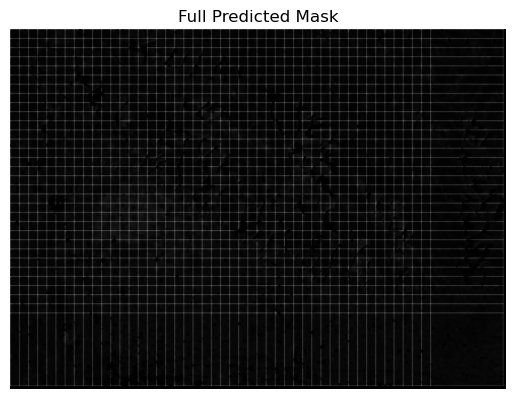

In [8]:
import matplotlib.pyplot as plt
def reconstruct_from_patches(patches, image_size, patch_size=(patch_size, patch_size), stride=32):
    H, W = image_size
    patch_H, patch_W = patch_size
    full_image = np.zeros((H, W, 1))  # Assuming single-channel output

    idx = 0
    for i in range(0, H - patch_H + 1, stride):
        for j in range(0, W - patch_W + 1, stride):
            full_image[i:i + patch_H, j:j + patch_W, :] = patches[idx]
            idx += 1

    return full_image

# Reconstruct full predicted mask
predicted_mask = reconstruct_from_patches(predictions, input_image.shape[:2])

# Visualize the final prediction
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title('Full Predicted Mask')
plt.axis('off')
plt.show()


In [9]:
import tifffile as tiff
# Save as TIFF
tiff.imwrite(output_predicted_mask_path, predicted_mask.astype(np.float32))